In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Task 1: Data Analysis and Cleaning
# -----------------------------------

# Read the dataset
df = pd.read_excel('ecom_data.xlsx')

# Display the first few rows
print("First few rows of the dataset:")
print(df.head())
print("+"*80)

# Check data types and missing values
print("\nDataset Information:")
print(df.info())
print("+"*80)

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())
print("+"*80)

# Check for duplicate entries
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")
print("+"*80)

# Drop duplicate rows if any
df.drop_duplicates(inplace=True)

# Convert 'Order Date' and 'Ship Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
print(df[['Sales', 'Quantity', 'Discount', 'Profit']].describe())
print("+"*80)


First few rows of the dataset:
         Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0  CA-2019-152156 2019-11-08 2019-11-11    Second Class    CG-12520   
1  CA-2019-152156 2019-11-08 2019-11-11    Second Class    CG-12520   
2  CA-2019-138688 2019-06-12 2019-06-16    Second Class    DV-13045   
3  US-2018-108966 2018-10-11 2018-10-18  Standard Class    SO-20335   
4  US-2018-108966 2018-10-11 2018-10-18  Standard Class    SO-20335   

  Country/Region             City       State  Postal Code Region  \
0  United States        Henderson    Kentucky      42420.0  South   
1  United States        Henderson    Kentucky      42420.0  South   
2  United States      Los Angeles  California      90036.0   West   
3  United States  Fort Lauderdale     Florida      33311.0  South   
4  United States  Fort Lauderdale     Florida      33311.0  South   

        Product ID         Category Sub-Category  \
0  FUR-BO-10001798        Furniture    Bookcases   
1  FUR-CH-10000454     

/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


# Conclusion:
We will focus on RFM (Recency, Frequency, Monetary) features for segmentation. There are features useful for segmentation:
- Customer ID
- Order Date
- Sales
- Quantity
- Profit
- Category
- Sub-Category
- Region

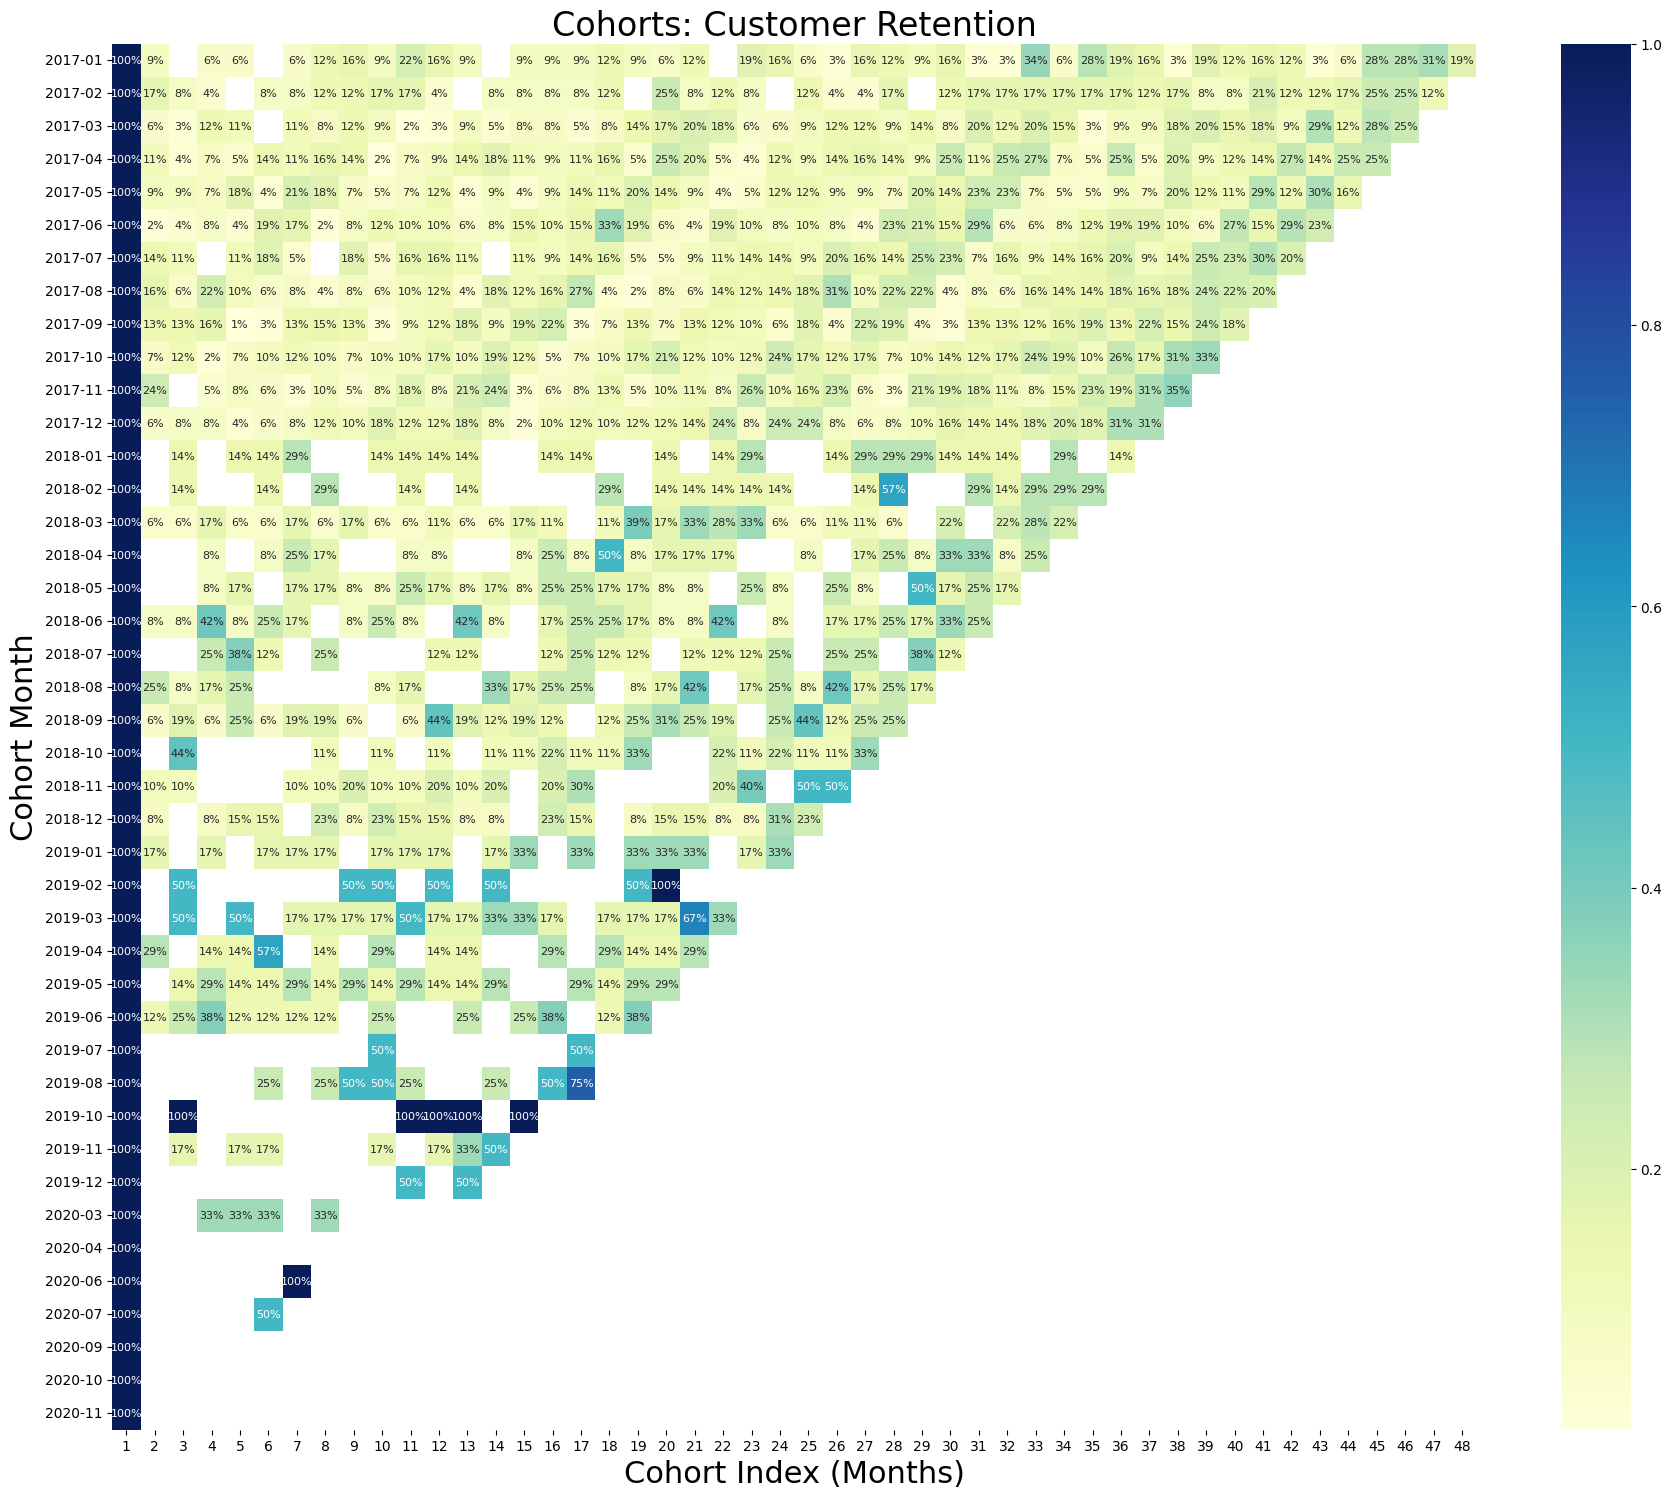

In [5]:
# Task 2: Cohort Analysis
# -----------------------

# Create 'OrderMonth' column
df['OrderMonth'] = df['Order Date'].dt.to_period('M')

# Create 'CohortMonth' column (customer's first purchase month)
df['CohortMonth'] = df.groupby('Customer ID')['Order Date'].transform('min').dt.to_period('M')

# Helper function to extract integer values from dates
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

# Get integer values for 'Order Date' and 'CohortMonth'
order_year, order_month = get_date_int(df, 'Order Date')
cohort_year, cohort_month = get_date_int(df, 'CohortMonth')

# Calculate the difference in years and months
years_diff = order_year - cohort_year
months_diff = order_month - cohort_month

# Calculate the cohort index
df['CohortIndex'] = years_diff * 12 + months_diff + 1

# Group by CohortMonth and CohortIndex to get the count of unique customers
grouping = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].apply(pd.Series.nunique).reset_index()
grouping.rename(columns={'Customer ID': 'CustomerCount'}, inplace=True)

# Create a pivot table to analyze retention
cohort_counts = grouping.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerCount')

# Calculate retention rate
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Visualize the retention rate
plt.figure(figsize=(22, 18))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu', annot_kws={"size": 8})  # Set annotation font size
plt.title('Cohorts: Customer Retention', fontsize=24)  # Set title font size
plt.ylabel('Cohort Month', fontsize=22)  # Set y-axis label font size
plt.xlabel('Cohort Index (Months)', fontsize=22)  # Set x-axis label font size
plt.xticks(fontsize=10)  # Set x-tick labels font size
plt.yticks(fontsize=10)  # Set y-tick labels font size
plt.savefig('cohort_analysis_retention.png', format='png')
plt.show()



The cohort analysis shows that customer retention drops significantly after the first month, with many not making repeat purchases. However, recent cohorts (2020) show better retention, indicating improvements in marketing or customer engagement strategies.

Key insights:
1. **High Initial Engagement**: All cohorts have 100% retention in the first month.
2. **Retention Drop**: A sharp decline occurs after the second month across all cohorts.
3. **Seasonal Effects**: Retention is higher during certain months, likely due to seasonal campaigns or promotions.
4. **Recent Improvements**: Retention has improved for newer cohorts, suggesting more effective strategies.

Recommendations:
- **Re-engagement Campaigns**: Target customers with follow-up offers or reminders after their first purchase.
- **Loyalty Programs**: Incentivize repeat purchases through discounts or rewards.
- **Customer Segmentation**: Tailor marketing efforts based on location, age, or communication preferences.
- **Optimized Communication**: Use preferred communication channels (email, SMS) to re-engage customers.

These strategies can help sustain customer activity and boost sales by leveraging data-driven insights.


RFM Table:
             Recency  Frequency  Monetary
Customer ID                              
AA-10315         185          5  5563.560
AA-10375          20          9  1056.390
AA-10480         260          4  1790.512
AA-10645          56          6  5086.935
AB-10015         417          3   886.156
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

RFM Segmentation Counts:
Segment
Loyal Customers        254
Potential Loyalists    219
Best Customers         124
Need Attention         116
At Risk                 80
Name: count, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/var/folders/y2/kyj4l2mn1794yrxqmgvvg4580000gn/T/ipykernel_8979/1685692866.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Monetary'] = np.log1p(X['Monetary'])
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, def

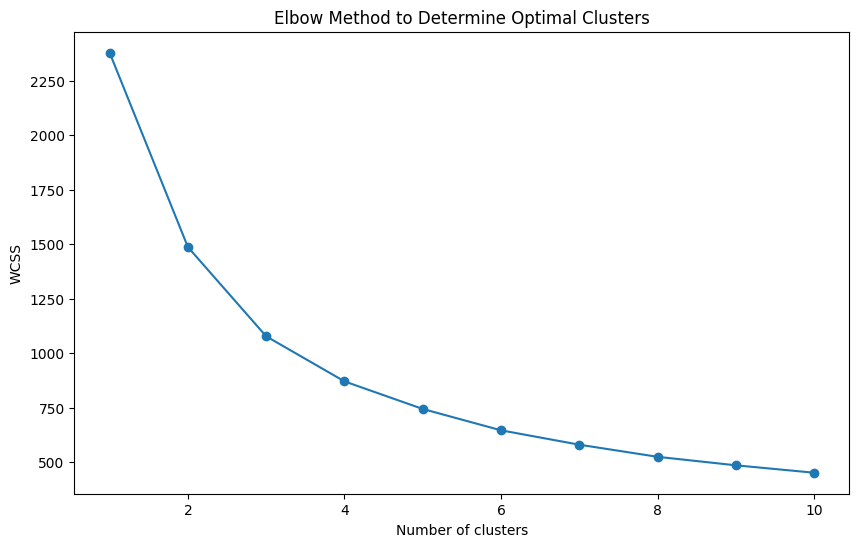

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Cluster Summary:
        Recency Frequency Monetary RFM_Score      
           mean      mean     mean      mean count
Cluster                                           
0          88.1       5.9   3238.3       9.5   333
1         571.3       3.8   1778.7       4.8    92
2          79.6       9.5   4310.1      12.2   223
3         121.7       3.9    646.7       5.7   145
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Comparison between RFM Segments and Clusters:
Cluster                0   1    2   3
Segment                              
At Risk                0  50    0  30
Best Customers        23   0  101   0
Loyal Customers      149   0  105   0
Need Attention        22  27    0  67
Potential Loyalists  139  15   17  48
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [6]:
# Task 3: RFM Analysis and Clustering
# -----------------------------------

# Define snapshot date as the day after the last order date
snapshot_date = df['Order Date'].max() + dt.timedelta(days=1)

# Aggregate data to compute RFM metrics
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'nunique',
    'Sales': 'sum'
})

# Rename columns to 'Recency', 'Frequency', 'Monetary'
rfm.rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Monetary'
}, inplace=True)

# Display the RFM table
print("\nRFM Table:")
print(rfm.head())
print("+"*80)

# Assign quintile scores to RFM metrics
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=r_labels)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=f_labels)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=m_labels)

# Calculate RFM Score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1).astype(int)

# Segment customers based on RFM Score
def rfm_level(df):
    if df['RFM_Score'] >= 13:
        return 'Best Customers'
    elif df['RFM_Score'] >= 10:
        return 'Loyal Customers'
    elif df['RFM_Score'] >= 7:
        return 'Potential Loyalists'
    elif df['RFM_Score'] >= 5:
        return 'Need Attention'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(rfm_level, axis=1)

# Display RFM segmentation counts
print("\nRFM Segmentation Counts:")
print(rfm['Segment'].value_counts())
print("+"*80)

# Prepare data for clustering
from sklearn.preprocessing import StandardScaler

X = rfm[['Recency', 'Frequency', 'Monetary']]

# Log transform the 'Monetary' feature to reduce skewness
X['Monetary'] = np.log1p(X['Monetary'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow method
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()
print("+"*80)

# From the Elbow Curve, choose the optimal number of clusters (e.g., 4)
optimal_clusters = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the clusters
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': ['mean', 'count']
}).round(1)

print("\nCluster Summary:")
print(cluster_summary)
print("+"*80)

# Compare RFM Segmentation and Clustering
comparison = pd.crosstab(rfm['Segment'], rfm['Cluster'])
print("\nComparison between RFM Segments and Clusters:")
print(comparison)
print("+"*80)


# Analysis:
**Cluster 2** aligns best with RFM segmentation for key customer segments. It captures 101 of the "Best Customers" and 105 "Loyal Customers," indicating strong customer value. This cluster shows high accuracy in identifying high-value segments, suggesting it is the best choice.

In [7]:
# Task 4: Customer Group Description
# ----------------------------------

# Describe each cluster based on RFM metrics
for cluster in rfm['Cluster'].unique():
    temp = rfm[rfm['Cluster'] == cluster]
    print(f"\nCluster {cluster} Description:")
    print(f"Number of Customers: {temp.shape[0]}")
    print(f"Average Recency: {temp['Recency'].mean():.1f} days")
    print(f"Average Frequency: {temp['Frequency'].mean():.1f} orders")
    print(f"Average Monetary Value: ${temp['Monetary'].mean():.2f}")
    print("+"*80)



Cluster 0 Description:
Number of Customers: 333
Average Recency: 88.1 days
Average Frequency: 5.9 orders
Average Monetary Value: $3238.28
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Cluster 2 Description:
Number of Customers: 223
Average Recency: 79.6 days
Average Frequency: 9.5 orders
Average Monetary Value: $4310.13
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Cluster 1 Description:
Number of Customers: 92
Average Recency: 571.3 days
Average Frequency: 3.8 orders
Average Monetary Value: $1778.70
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Cluster 3 Description:
Number of Customers: 145
Average Recency: 121.7 days
Average Frequency: 3.9 orders
Average Monetary Value: $646.72
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Here are the key characteristics of each cluster:

**Cluster 0:**
```
Number of Customers: 333
Average Recency: 88.1 days (Moderate recency)
Average Frequency: 5.9 orders (Moderate frequency)
Average Monetary Value: $3238.28 (High spending)
```

**Cluster 2:**
```
Number of Customers: 223
Average Recency: 79.6 days (Recent purchases)
Average Frequency: 9.5 orders (High frequency)
Average Monetary Value: $4310.13 (Very high spending)
```

**Cluster 1:**
```
Number of Customers: 92
Average Recency: 571.3 days (Very infrequent purchases)
Average Frequency: 3.8 orders (Low frequency)
Average Monetary Value: $1778.70 (Moderate spending)
```

**Cluster 3:**
```
Number of Customers: 145
Average Recency: 121.7 days (Less recent purchases)
Average Frequency: 3.9 orders (Low frequency)
Average Monetary Value: $646.72 (Low spending)
```

# Significant Characteristics:

- Clusters with low recency (recent purchases), high frequency, and high monetary value are the best customers.
- Clusters with high recency (long time since last purchase), low frequency, and low monetary value are at risk.

**Cluster 2**: Best customers, frequent buyers with high spending.

**Cluster 1**: Very inactive, infrequent buyers with moderate spending.

**Cluster 3**: Low spenders with infrequent purchases.

In [8]:
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment,Cluster
Customer ID,,,,,,,,,
AA-10315,185,5,5563.560,2,2,5,9,Potential Loyalists,0
AA-10375,20,9,1056.390,5,5,2,12,Loyal Customers,2
AA-10480,260,4,1790.512,1,1,3,5,Need Attention,0
AA-10645,56,6,5086.935,3,3,5,11,Loyal Customers,0
AB-10015,417,3,886.156,1,1,1,3,At Risk,1
...,...,...,...,...,...,...,...,...,...
XP-21865,44,11,2374.658,4,5,3,12,Loyal Customers,2
YC-21895,5,5,5454.350,5,3,5,13,Best Customers,0
YS-21880,10,8,6720.444,5,4,5,14,Best Customers,2


In [9]:
# Task 5: KPI Selection for Each Segment
# --------------------------------------

# Define KPIs for each segment
kpi_dict = {
    'Best Customers':       ['Increase Loyalty Programs', 'Upselling Opportunities'],
    'Loyal Customers':      ['Maintain Engagement', 'Cross-selling Products'],
    'Potential Loyalists':  ['Encourage More Frequent Purchases', 'Targeted Promotions'],
    'Need Attention':       ['Reactivation Campaigns', 'Feedback Collection'],
    'At Risk':              ['Win-back Strategies', 'Special Discounts']
}

# Assign KPIs to each customer based on their segment
rfm['KPIs'] = rfm['Segment'].map(kpi_dict)

# Display the KPIs for each segment
print("\nKPIs for Each Segment:")
for segment in rfm['Segment'].unique():
    print(f"\nSegment: {segment}")
    print(f"KPIs: {', '.join(kpi_dict[segment])}")
    print("+"*80)



KPIs for Each Segment:

Segment: Potential Loyalists
KPIs: Encourage More Frequent Purchases, Targeted Promotions
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Segment: Loyal Customers
KPIs: Maintain Engagement, Cross-selling Products
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Segment: Need Attention
KPIs: Reactivation Campaigns, Feedback Collection
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Segment: At Risk
KPIs: Win-back Strategies, Special Discounts
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Segment: Best Customers
KPIs: Increase Loyalty Programs, Upselling Opportunities
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Here are the suggested KPIs for each segment, with specific actions:

### 1. **Best Customers**  
- **Increase retention rate**: Keep these high-value customers coming back.
- **Increase average order value (AOV)**: Encourage them to buy higher-value items or more items per order.
- **Strategy**: Use loyalty programs and upsell premium products.

### 2. **Loyal Customers**  
- **Maintain retention**: Ensure consistent engagement from these frequent buyers.
- **Cross-sell/upsell products**: Offer complementary or higher-value items.
- **Strategy**: Tailored promotions and product suggestions.

### 3. **Potential Loyalists**  
- **Increase purchase frequency**: Encourage more frequent shopping.
- **Shorten time between orders**: Get customers to return sooner for their next purchase.
- **Strategy**: Targeted promotions and incentives.

### 4. **Need Attention**  
- **Re-engage inactive customers**: Bring them back into the purchasing cycle.
- **Collect feedback**: Understand why they’ve become less active.
- **Strategy**: Use reactivation campaigns and feedback collection.

### 5. **At Risk**  
- **Decrease churn**: Prevent these customers from leaving entirely.
- **Boost engagement with discounts**: Use special offers to win them back.
- **Strategy**: Personalized offers and win-back strategies.


# Hypothesis testing

In [30]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
from datetime import date, time, datetime
from operator import attrgetter
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_excel('ecom_data.xlsx', sheet_name=['Orders','Customers','Sales_people','Returns'])

orders = data['Orders']
customers = data['Customers']
sales_people = data['Sales_people']
returns = data['Returns']

orders_customers = pd.merge(orders, customers, on='Customer ID', how='left')
orders_customers.head()

/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State,Postal Code,Region,...,Discount,Profit,Segment,Country,CityOfLiving,Phone,Email_falg,App,App_push,website_registration_date
0,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,...,0.00,41.9136,Consumer,United States,Henderson,1,1,1,0,2018-10-20
1,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,...,0.00,219.5820,Consumer,United States,Henderson,1,1,1,0,2018-10-20
2,CA-2019-138688,2019-06-12,2019-06-16,Second Class,DV-13045,United States,Los Angeles,California,90036.0,West,...,0.00,6.8714,Corporate,United States,Los Angeles,1,1,1,1,2019-06-16
3,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,...,0.45,-383.0310,Consumer,United States,Fort Lauderdale,1,1,0,0,2018-09-30
4,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,...,0.20,2.5164,Consumer,United States,Fort Lauderdale,1,1,0,0,2018-09-30


In [13]:
# merge (orders with customers) with returns on left
orders_customers_returns = pd.merge(orders_customers, returns, on='Order ID', how='left')
orders_customers_returns.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State,Postal Code,Region,...,Profit,Segment,Country,CityOfLiving,Phone,Email_falg,App,App_push,website_registration_date,Returned
0,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,...,41.9136,Consumer,United States,Henderson,1,1,1,0,2018-10-20,NaN
1,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,...,219.5820,Consumer,United States,Henderson,1,1,1,0,2018-10-20,NaN
2,CA-2019-138688,2019-06-12,2019-06-16,Second Class,DV-13045,United States,Los Angeles,California,90036.0,West,...,6.8714,Corporate,United States,Los Angeles,1,1,1,1,2019-06-16,NaN
3,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,...,-383.0310,Consumer,United States,Fort Lauderdale,1,1,0,0,2018-09-30,NaN
4,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,...,2.5164,Consumer,United States,Fort Lauderdale,1,1,0,0,2018-09-30,NaN


In [14]:
# make final data => merge (orders with customers with returns) with sales_people on left
final_data = pd.merge(orders_customers_returns, sales_people, on='Region', how='left')
final_data.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State,Postal Code,Region,...,Segment,Country,CityOfLiving,Phone,Email_falg,App,App_push,website_registration_date,Returned,Person
0,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,...,Consumer,United States,Henderson,1,1,1,0,2018-10-20,NaN,Cassandra Brandow
1,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,...,Consumer,United States,Henderson,1,1,1,0,2018-10-20,NaN,Cassandra Brandow
2,CA-2019-138688,2019-06-12,2019-06-16,Second Class,DV-13045,United States,Los Angeles,California,90036.0,West,...,Corporate,United States,Los Angeles,1,1,1,1,2019-06-16,NaN,Anna Andreadi
3,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,...,Consumer,United States,Fort Lauderdale,1,1,0,0,2018-09-30,NaN,Cassandra Brandow
4,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,...,Consumer,United States,Fort Lauderdale,1,1,0,0,2018-09-30,NaN,Cassandra Brandow


In [15]:
# see NaNs in column Returned -> have to fillna with (No) cause in table returns had info only about orders which already returns (Yes)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12420 entries, 0 to 12419
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Order ID                   12420 non-null  object        
 1   Order Date                 12420 non-null  datetime64[ns]
 2   Ship Date                  12420 non-null  datetime64[ns]
 3   Ship Mode                  12420 non-null  object        
 4   Customer ID                12420 non-null  object        
 5   Country/Region             12420 non-null  object        
 6   City                       12420 non-null  object        
 7   State                      12420 non-null  object        
 8   Postal Code                12409 non-null  float64       
 9   Region                     12420 non-null  object        
 10  Product ID                 12420 non-null  object        
 11  Category                   12420 non-null  object        
 12  Sub-

In [16]:
#fillna with No
final_data['Returned'] = final_data['Returned'].fillna('No')

In [17]:
final_data['Returned'].value_counts()

Returned
No     9194
Yes    3226
Name: count, dtype: int64

In [18]:
final_data.describe()

,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit,Phone,Email_falg,App,App_push,website_registration_date
count,12420,12420,12409.000000,12420.000000,12420.000000,12420.000000,12420.000000,12420.0,12420.000000,12420.000000,12420.000000,12420
mean,2019-05-13 14:10:46.956521728,2019-05-17 12:07:39.130434816,57417.516480,233.629369,3.785024,0.154403,28.995935,1.0,0.898470,0.590741,0.312560,2017-08-23 07:30:46.956521728
min,2017-01-03 00:00:00,2017-01-07 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000,1.0,0.000000,0.000000,0.000000,2016-10-12 00:00:00
25%,2018-05-28 00:00:00,2018-06-01 00:00:00,24153.000000,17.904000,2.000000,0.000000,1.969800,1.0,1.000000,0.000000,0.000000,2017-03-19 00:00:00
50%,2019-07-18 00:00:00,2019-07-23 12:00:00,60623.000000,55.392000,3.000000,0.150000,9.072000,1.0,1.000000,1.000000,0.000000,2017-07-13 00:00:00
75%,2020-06-08 00:00:00,2020-06-10 00:00:00,90045.000000,212.680000,5.000000,0.200000,29.372000,1.0,1.000000,1.000000,1.000000,2017-11-09 00:00:00
max,2020-12-30 00:00:00,2021-01-05 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000,1.0,1.000000,1.000000,1.000000,2020-10-11 00:00:00
std,NaN,NaN,32749.815711,620.762848,2.231328,0.206124,246.506696,0.0,0.302041,0.491717,0.463555,NaN


In [19]:
# drop 11 lines where no info about postal code
final_data.dropna()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State,Postal Code,Region,...,Segment,Country,CityOfLiving,Phone,Email_falg,App,App_push,website_registration_date,Returned,Person
0,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,...,Consumer,United States,Henderson,1,1,1,0,2018-10-20,No,Cassandra Brandow
1,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,...,Consumer,United States,Henderson,1,1,1,0,2018-10-20,No,Cassandra Brandow
2,CA-2019-138688,2019-06-12,2019-06-16,Second Class,DV-13045,United States,Los Angeles,California,90036.0,West,...,Corporate,United States,Los Angeles,1,1,1,1,2019-06-16,No,Anna Andreadi
3,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,...,Consumer,United States,Fort Lauderdale,1,1,0,0,2018-09-30,No,Cassandra Brandow
4,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,...,Consumer,United States,Fort Lauderdale,1,1,0,0,2018-09-30,No,Cassandra Brandow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12415,CA-2020-121258,2020-02-26,2020-03-03,Standard Class,DB-13060,United States,Costa Mesa,California,92627.0,West,...,Consumer,United States,Seattle,1,1,0,0,2017-01-23,Yes,Anna Andreadi
12416,CA-2020-121258,2020-02-26,2020-03-03,Standard Class,DB-13060,United States,Costa Mesa,California,92627.0,West,...,Consumer,United States,Seattle,1,1,0,0,2017-01-23,Yes,Anna Andreadi
12417,CA-2020-121258,2020-02-26,2020-03-03,Standard Class,DB-13060,United States,Costa Mesa,California,92627.0,West,...,Consumer,United States,Seattle,1,1,0,0,2017-01-23,Yes,Anna Andreadi
12418,CA-2020-121258,2020-02-26,2020-03-03,Standard Class,DB-13060,United States,Costa Mesa,California,92627.0,West,...,Consumer,United States,Seattle,1,1,0,0,2017-01-23,Yes,Anna Andreadi


In [20]:
segment_data = pd.merge(final_data, rfm, on='Customer ID', how='left')

In [21]:
segment_data['Ship Mode'].value_counts()

Ship Mode
Standard Class    7312
Second Class      2263
First Class       1980
Same Day           865
Name: count, dtype: int64

In [22]:
segment_data.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Country/Region', 'City', 'State', 'Postal Code', 'Region',
       'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Segment_x', 'Country',
       'CityOfLiving', 'Phone', 'Email_falg', 'App', 'App_push',
       'website_registration_date', 'Returned', 'Person', 'Recency',
       'Frequency', 'Monetary', 'R', 'F', 'M', 'RFM_Score', 'Segment_y',
       'Cluster', 'KPIs'],
      dtype='object')

## Hypothesis 1: The impact of discounts on sales volume and profit
### Initiative: Introduction of a dynamic discount system to stimulate sales.

H0: There is no statistically significant difference in the average sales volume and profit between orders with applied discounts and those without discounts.

H1: Orders with applied discounts have a statistically significantly higher average sales volume and profit compared to orders without discounts.

In [23]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Разделение данных на две группы: с скидкой и без скидки
discounted = segment_data[segment_data['Discount'] > 0]['Sales']
non_discounted = segment_data[segment_data['Discount'] == 0]['Sales']

# Проверка нормальности распределения
stat_discounted, p_discounted = shapiro(discounted.sample(5000, random_state=1))  # Выборка для ускорения
stat_non_discounted, p_non_discounted = shapiro(non_discounted.sample(5000, random_state=1))

if p_discounted > 0.05 and p_non_discounted > 0.05:
    # Используем t-тест
    stat, p_value = ttest_ind(discounted, non_discounted, equal_var=False)
    test_used = "t-тест"
else:
    # Используем U-тест Манна-Уитни
    stat, p_value = mannwhitneyu(discounted, non_discounted)
    test_used = "U-тест Манна-Уитни"

# Вывод результатов
print(f"Использованный метод: {test_used}")
print(f"Статистика теста: {stat}")
print(f"P-значение: {p_value}\n")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print("Conclusion: Reject H0. Discounts affect sales volume.")
else:
    print("Conclusion: There is no reason to reject H1. Discounts do not affect sales volume.")


Использованный метод: U-тест Манна-Уитни
Статистика теста: 19545742.5
P-значение: 0.1554126192251376

Conclusion: There is no reason to reject H1. Discounts do not affect sales volume.


In [24]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Разделение данных на две группы: с скидкой и без скидки
discounted = segment_data[segment_data['Discount'] > 0]['Profit']
non_discounted = segment_data[segment_data['Discount'] == 0]['Profit']

# Проверка нормальности распределения
stat_discounted, p_discounted = shapiro(discounted.sample(5000, random_state=1))  # Выборка для ускорения
stat_non_discounted, p_non_discounted = shapiro(non_discounted.sample(5000, random_state=1))

if p_discounted > 0.05 and p_non_discounted > 0.05:
    # Используем t-тест
    stat, p_value = ttest_ind(discounted, non_discounted, equal_var=False)
    test_used = "t-тест"
else:
    # Используем U-тест Манна-Уитни
    stat, p_value = mannwhitneyu(discounted, non_discounted)
    test_used = "U-тест Манна-Уитни"

# Вывод результатов
print(f"Использованный метод: {test_used}")
print(f"Статистика теста: {stat}")
print(f"P-значение: {p_value}\n")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print("Conclusion: Reject H0. Discounts affect profit volume.")
else:
    print("Conclusion: There is no reason to reject H1. Discounts do not affect profit volume.")


Использованный метод: U-тест Манна-Уитни
Статистика теста: 10265067.0
P-значение: 0.0

Conclusion: Reject H0. Discounts affect profit volume.


## Hypothesis 2: The impact of delivery method on profit
### Initiative: Optimization of delivery methods to increase profit margins.
H0: There is no statistically significant difference in average profit between different delivery methods (Ship Mode).

H1: There is a statistically significant difference in average profit between different delivery methods (Ship Mode).

In [25]:
segment_data['Ship Mode'].unique()

array(['Second Class', 'Standard Class', 'First Class', 'Same Day'],
      dtype=object)

In [26]:
from scipy.stats import f_oneway, kruskal, levene, shapiro

# Группировка прибыли по способам доставки
ship_modes = segment_data['Ship Mode'].unique()
groups = [segment_data[segment_data['Ship Mode'] == mode]['Profit'] for mode in ship_modes]

# Проверка нормальности для каждой группы
normal = all([shapiro(group)[1] > 0.05 for group in groups])

# Проверка однородности дисперсий
homogeneity = levene(*groups).pvalue > 0.05

if normal and homogeneity:
    # Используем ANOVA
    stat, p_value = f_oneway(*groups)
    test_used = "ANOVA"
else:
    # Используем Критерий Краскела-Уоллиса
    stat, p_value = kruskal(*groups)
    test_used = "Kruskal-Wallis test"

# Вывод результатов
print(f"Использованный метод: {test_used}")
print(f"Статистика теста: {stat}")
print(f"P-значение: {p_value}\n")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print("Conclusion: Reject H0. Shipping method affects profit.")
else:
    print("Conclusion: No reason to reject H0. Shipping method does not affect profit.")


Использованный метод: Kruskal-Wallis test
Статистика теста: 46.40033593847801
P-значение: 4.661976234804096e-10

Conclusion: Reject H0. Shipping method affects profit.


/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Hypothesis 3: The impact of delivery region on total profit
### Initiative: Optimization of logistics processes in regions with low profitability.
H0: There is no statistically significant difference in average profit between different delivery regions (Region).

H1: There is a statistically significant difference in average profit between different delivery regions (Region).

In [27]:
# Группировка прибыли по регионам
regions = segment_data['Region'].unique()
groups = [segment_data[segment_data['Region'] == region]['Profit'] for region in regions]

# Проверка нормальности
normal = all([shapiro(group)[1] > 0.05 for group in groups])

# Проверка однородности дисперсий
homogeneity = levene(*groups).pvalue > 0.05

if normal and homogeneity:
    # Используем ANOVA
    stat, p_value = f_oneway(*groups)
    test_used = "ANOVA"
else:
    # Используем Критерий Краскела-Уоллиса
    stat, p_value = kruskal(*groups)
    test_used = "Kruskal-Wallis test"

# Вывод результатов
print(f"Использованный метод: {test_used}")
print(f"Статистика теста: {stat}")
print(f"P-значение: {p_value}\n")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print("Conclusion: Reject H0. Delivery region affects overall profit.")
else:
    print("Conclusion: No reason to reject H1. Delivery region does not affect overall profit.")


Использованный метод: Kruskal-Wallis test
Статистика теста: 319.8695421996246
P-значение: 4.977248980482032e-69

Conclusion: Reject H0. Delivery region affects overall profit.


In [28]:
segment_data['Segment_y'].unique()

array(['At Risk', 'Potential Loyalists', 'Loyal Customers',
       'Best Customers', 'Need Attention'], dtype=object)

## Hypothesis 4: The influence of the service worker on customer segmentation.
### Initiative: Implementation of KPI for employees/conducting additional training

H0: There is no statistically significant relationship between the service person (Person) and the customer segment (Segment_y).

H1: There is a statistically significant relationship between the service person (Person) and the customer segment (Segment_y).

Статистика хи-квадрат: 182.62296308567144
P-значение: 1.2346545014534035e-32
Conclusion: p-value = 0.00000 < 0.05. Reject H0.
There is a statistically significant relationship between the service person and the customer segment.


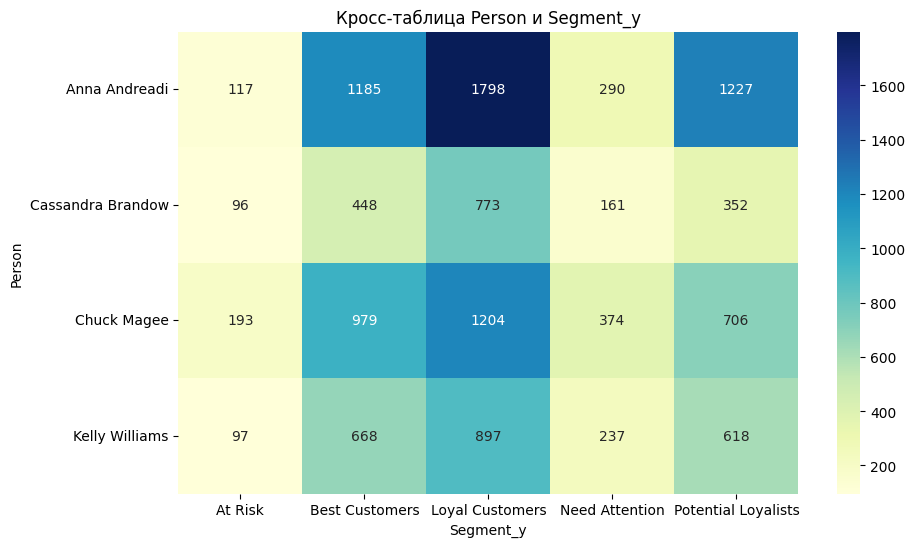

In [31]:
# Построение кросс-таблицы для Person и Segment_y
contingency_table = pd.crosstab(segment_data['Person'], segment_data['Segment_y'])

# Тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Вывод результатов
print(f"Статистика хи-квадрат: {chi2}")
print(f"P-значение: {p_value}")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print(f"Conclusion: p-value = {p_value:.5f} < {alpha}. Reject H0.")
    print("There is a statistically significant relationship between the service person and the customer segment.")
else:
    print(f"Conclusion: p-value = {p_value:.5f} >= {alpha}. Couldn't reject H0.")
    print("There is no statistically significant relationship between service person and customer segment.")
# Визуализация кросс-таблицы
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Кросс-таблица Person и Segment_y')
plt.ylabel('Person')
plt.xlabel('Segment_y')
plt.show()


## Hypothesis 5: Impact of customer type on RFM segmentation.
### Initiative: Personalized strategies and loyalty programs for different customer types

H0: There is no statistically significant relationship between the customer type (Segment_x: consumer, corporate, home office) and its RFM segment (Segment_y).

H1: There is a statistically significant relationship between the customer type (Segment_x: consumer, corporate, home office) and its RFM segment (Segment_y).

Статистика хи-квадрат: 161.98951074010748
P-значение: 6.135175287330653e-31
Conclusion: p-value = 0.00000 < 0.05. Reject H0.
There is a statistically significant relationship between customer type and the customer segment.


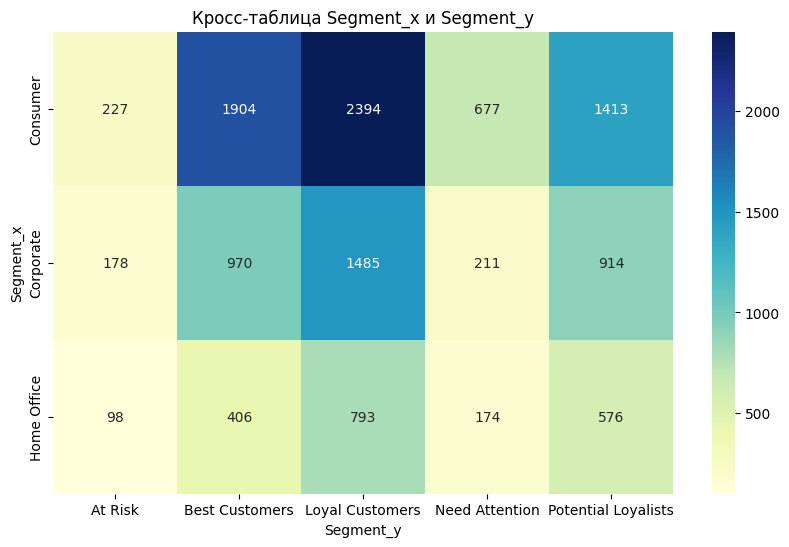

In [39]:
# Построение кросс-таблицы для Person и Segment_y
contingency_table = pd.crosstab(segment_data['Segment_x'], segment_data['Segment_y'])

# Тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Вывод результатов
print(f"Статистика хи-квадрат: {chi2}")
print(f"P-значение: {p_value}")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print(f"Conclusion: p-value = {p_value:.5f} < {alpha}. Reject H0.")
    print("There is a statistically significant relationship between customer type and the customer segment.")
else:
    print(f"Conclusion: p-value = {p_value:.5f} >= {alpha}. Couldn't reject H0.")
    print("There is no statistically significant relationship between customer type and the customer segment.")

# Визуализация кросс-таблицы
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Кросс-таблица Segment_x и Segment_y')
plt.ylabel('Segment_x')
plt.xlabel('Segment_y')
plt.show()


## Hypothesis 6: Impact of purchase category on RFM segmentation.
### Initiative: Tailored strategies and promotions based on purchase categories

H0: There is no statistically significant relationship between the purchase category and its RFM segment (Segment_y).

H1: There is a statistically significant relationship between the purchase category and its RFM segment (Segment_y).

Статистика хи-квадрат: 42.26471717951823
P-значение: 1.2078039271191052e-06
Conclusion: p-value = 0.00000 < 0.05. Reject H0.
There is a statistically significant relationship between purchase category and the customer segment.


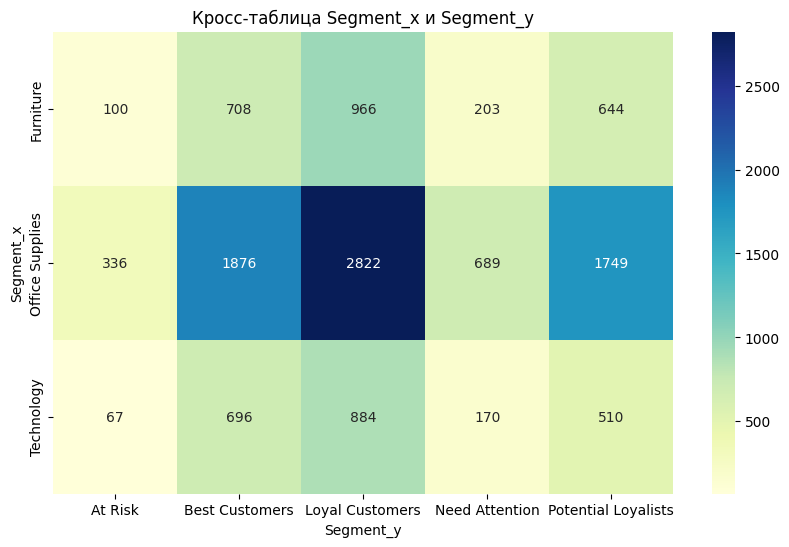

In [40]:
# Построение кросс-таблицы для Person и Segment_y
contingency_table = pd.crosstab(segment_data['Category'], segment_data['Segment_y'])

# Тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Вывод результатов
print(f"Статистика хи-квадрат: {chi2}")
print(f"P-значение: {p_value}")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print(f"Conclusion: p-value = {p_value:.5f} < {alpha}. Reject H0.")
    print("There is a statistically significant relationship between purchase category and the customer segment.")
else:
    print(f"Conclusion: p-value = {p_value:.5f} >= {alpha}. Couldn't reject H0.")
    print("There is no statistically significant relationship between purchase category and the customer segment.")

# Визуализация кросс-таблицы
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Кросс-таблица Segment_x и Segment_y')
plt.ylabel('Segment_x')
plt.xlabel('Segment_y')
plt.show()


## Hypothesis 7: Impact of product returns on RFM segmentation.
### Initiative: Understanding the influence of product returns on customer behavior
H0: Product returns (Returned) have no statistically significant impact on the distribution of customers across RFM segments (Segment_y: At Risk, Best Customers, Loyal Customers, Need Attention, Potential Loyalists).

H1: Product returns (Returned) have a statistically significant impact on the distribution of customers across RFM segments (Segment_y: At Risk, Best Customers, Loyal Customers, Need Attention, Potential Loyalists).

Статистика хи-квадрат: 106.93866940550123
P-значение: 3.2712599628192565e-22
Conclusion: p-value = 0.00000 < 0.05. Reject H0.
There is a statistically significant relationship between product returns and the customer segment.


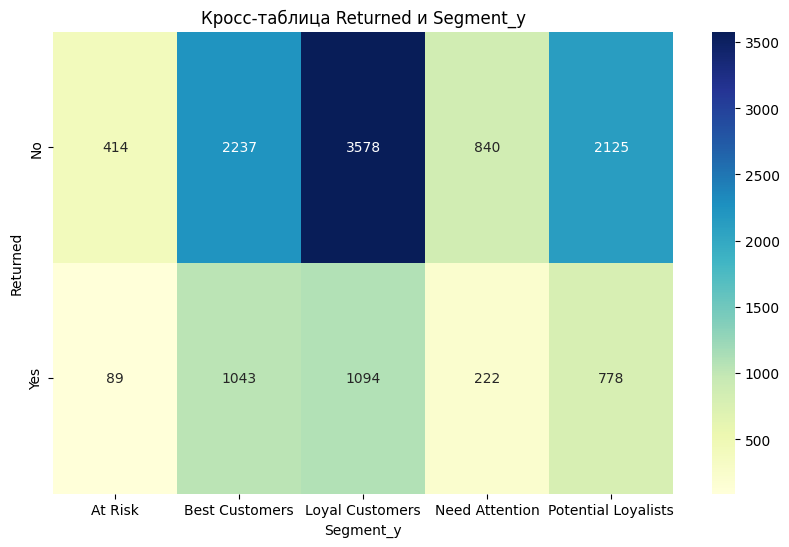

In [48]:
# Построение кросс-таблицы для Returned и Segment_y
contingency_table = pd.crosstab(segment_data['Returned'], segment_data['Segment_y'])

# Тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Вывод результатов
print(f"Статистика хи-квадрат: {chi2}")
print(f"P-значение: {p_value}")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print(f"Conclusion: p-value = {p_value:.5f} < {alpha}. Reject H0.")
    print("There is a statistically significant relationship between product returns and the customer segment.")
else:
    print(f"Conclusion: p-value = {p_value:.5f} >= {alpha}. Couldn't reject H0.")
    print("There is no statistically significant relationship between product returns and the customer segment.")

# Визуализация кросс-таблицы
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Кросс-таблица Returned и Segment_y')
plt.ylabel('Returned')
plt.xlabel('Segment_y')
plt.show()


## Hypothesis 8: Impact of mobile app usage on customer segmentation.
### Initiative: Understanding the effect of mobile app engagement on customer behavior
H0: The use of the mobile app (App, App_push) has no statistically significant effect on the distribution of customers across RFM segments (Segment_y: At Risk, Best Customers, Loyal Customers, Need Attention, Potential Loyalists).

H1: The use of the mobile app (App, App_push) has a statistically significant effect on the distribution of customers across RFM segments (Segment_y: At Risk, Best Customers, Loyal Customers, Need Attention, Potential Loyalists).

Статистика хи-квадрат: 225.45420668609023
P-значение: 1.2563337734720644e-47
Conclusion: p-value = 0.00000 < 0.05. Reject H0.
There is a statistically significant relationship between mobile app usage and the customer segment.


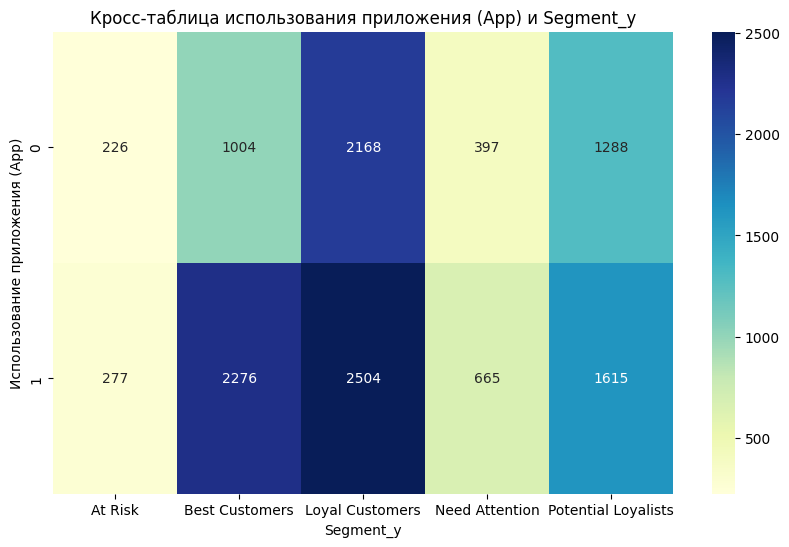

In [52]:
# Построение кросс-таблицы для использования приложения (App) и сегментации (Segment_y)
contingency_table = pd.crosstab(segment_data['App'], segment_data['Segment_y'])

# Тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Вывод результатов
print(f"Статистика хи-квадрат: {chi2}")
print(f"P-значение: {p_value}")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print(f"Conclusion: p-value = {p_value:.5f} < {alpha}. Reject H0.")
    print("There is a statistically significant relationship between mobile app usage and the customer segment.")
else:
    print(f"Conclusion: p-value = {p_value:.5f} >= {alpha}. Couldn't reject H0.")
    print("There is no statistically significant relationship between mobile app usage and the customer segment.")

# Визуализация кросс-таблицы
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Кросс-таблица использования приложения (App) и Segment_y')
plt.ylabel('Использование приложения (App)')
plt.xlabel('Segment_y')
plt.show()
